# Pose Approximation Refinement

Expected Data format:

- `x` - images (B, 224, 224, 3)
- `y` - ground truth vertices for hand landmarks (B, 21, 2)

In [24]:
import torch

class classproperty(property):
    def __get__(self, obj, cls):
        return self.fget(cls)

class Hand:
    # NOTE: MediaPipe 21 point Hand landmark model: https://mediapipe.readthedocs.io/en/latest/solutions/hands.html
    _RAW_CONNECTIONS = [
        (0,1), (0,5), (0,17), (1,2), (2,3), (3,4),
        (5,6), (5,9), (6,7), (7,8), (9,10), (9,13),
        (10,11), (11,12), (13,14), (13,17), (14,15),
        (15,16), (17,18), (18,19), (19,20)
    ]

    NUM_POINTS = 21
    NUM_FEATURES = 2 # x, y only
    
    @classproperty
    def anatomical(cls):
        # Create the edge list and make it undirected by adding reverse connections (same for all graphs)
        temp = []
        for a, b in cls._RAW_CONNECTIONS:
            temp.append([a, b])
            temp.append([b, a])  # Add the reverse connection
        return temp
    
    @classproperty
    def inverse_anatomical(cls):
        inverse_graph_connections = []
        for i in range(21):
            for j in range(21):
                conn = (i, j)
                if conn not in cls._RAW_CONNECTIONS and i != j:
                    inverse_graph_connections.append(conn)
        return inverse_graph_connections
    
    @staticmethod
    def compute_edge_index(connection_choice):
        return torch.tensor(connection_choice, dtype=torch.long).t().contiguous()

Hand.compute_edge_index(Hand.anatomical)

tensor([[ 0,  1,  0,  5,  0, 17,  1,  2,  2,  3,  3,  4,  5,  6,  5,  9,  6,  7,
          7,  8,  9, 10,  9, 13, 10, 11, 11, 12, 13, 14, 13, 17, 14, 15, 15, 16,
         17, 18, 18, 19, 19, 20],
        [ 1,  0,  5,  0, 17,  0,  2,  1,  3,  2,  4,  3,  6,  5,  9,  5,  7,  6,
          8,  7, 10,  9, 13,  9, 11, 10, 12, 11, 14, 13, 17, 13, 15, 14, 16, 15,
         18, 17, 19, 18, 20, 19]])

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import lmdb

class PoseLMDBDataset(Dataset):
    def __init__(self, lmdb_path):
        self.env = lmdb.open(lmdb_path,
            readonly=True, lock=False,
            readahead=False, meminit=False)
        self.txn = self.env.begin(write=False)
        self.length = self.txn.stat()['entries']

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        key = f"{idx:08d}".encode('ascii')
        byteflow = self.txn.get(key)
        sample = pickle.loads(byteflow)
        img = sample["image"]
        label = sample["label"]

        img = torch.from_numpy(img).float() / 255.0
        return img, torch.tensor(label)

In [26]:
from torch.utils.data import random_split, DataLoader

dataset = PoseLMDBDataset("training_data.lmdb")

# Split lengths for train (80%), test (10%), valid (10%)
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

torch.Size([256, 224, 224, 3]) torch.Size([256, 21, 2])


c:\BME\projects\frei-hands\freihand\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TypeError: tuple indices must be integers or slices, not str

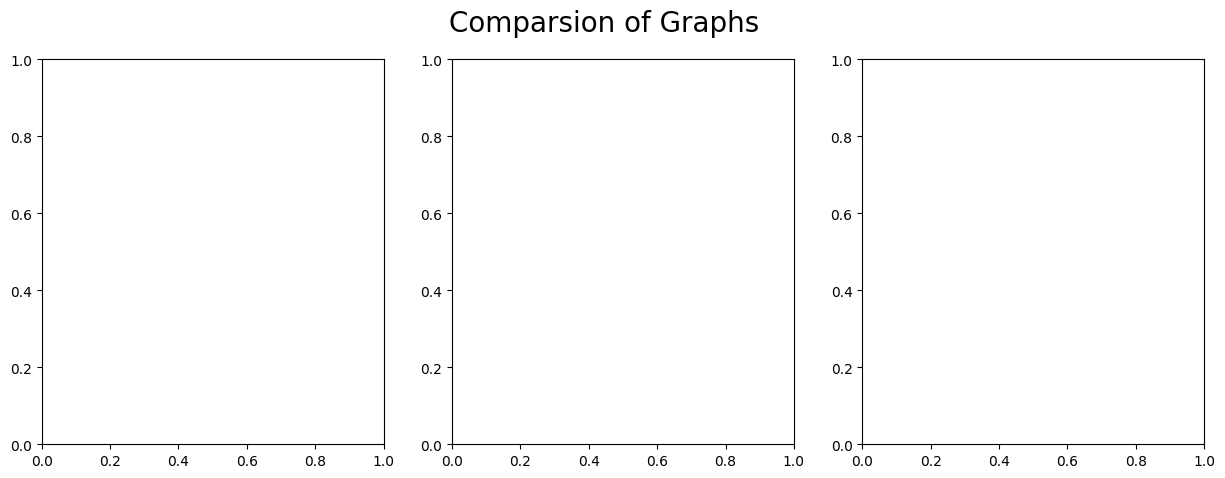

In [27]:
import random
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graphs_side_by_side(dataset, indices):
    num_graphs = len(indices)
    fig, axs = plt.subplots(1, num_graphs, figsize=(5 * num_graphs, 5))
    axs = [axs] if num_graphs == 1 else axs

    fig.suptitle("Comparsion of Graphs", fontsize=20)

    for ax, idx in zip(axs, indices):
        data = dataset[idx]
        mp_lms = data["mediapipe_lms"].numpy()
        real_lms = data["real_lms"].numpy()
        img = data["image"].numpy() # shape (H, W, 3), normalized 0-1

        # Background image (fit to 0-1 coordinate space)
        ax.imshow(img, extent=[0, 1, 0, 1], origin='upper', aspect='auto')

        # Graph edges
        edge_index = Hand.compute_edge_index(Hand.anatomical).numpy()
        G = nx.Graph()
        G.add_edges_from(edge_index.T)

        # Node features
        x1, y1 = mp_lms[:, 0], mp_lms[:, 1]
        y1 = 1.0 - y1
        pos_x = {i: (x1[i], y1[i]) for i in range(len(x1))}
        nx.draw_networkx_nodes(G, pos_x, node_size=50, node_color='blue', ax=ax)
        nx.draw_networkx_edges(G, pos_x, width=1.5, alpha=0.7, ax=ax)

        x2, y2 = real_lms[:, 0], real_lms[:, 1]
        y2 = 1.0 - y2
        pos_y = {i: (x2[i], y2[i]) for i in range(len(x2))}
        nx.draw_networkx_nodes(G, pos_y, node_size=50, node_color='red', ax=ax)

        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.invert_yaxis()  # optional, depends on how you want y-axis
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize=12)
        ax.set_xlabel("X-axis", fontsize=14)
        ax.set_ylabel("Y-axis", fontsize=14)

    plt.tight_layout()
    plt.show()

# Example usage
random_indices = random.sample(range(len(dataset)), 3)
random_indices = [0,1,2]
visualize_graphs_side_by_side(dataset, indices=random_indices)

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MobileGNNConv(nn.Module):
    """Custom implementation of GCNConv in Pytorch for Static ASL Fingerspelling sign classification.

    The implementation optimizes the general GCN by making the adjacency matrix, denoted 'A', fixed in size for classic batching.
    It also allows for optimizing the values of the said matrix via gradient descent and dynamically freezing the weights.
    """
    def __init__(self, input_dim: int, output_dim: int):
        super(MobileGNNConv, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lin = nn.Linear(input_dim, output_dim, bias=False)

        A = torch.zeros((Hand.NUM_POINTS, Hand.NUM_POINTS))
        for x, y in Hand.anatomical:
          A[x, y] = 1

        A_hat = A + torch.eye(A.size(0)) # self loops
        D = torch.diag(A_hat.sum(dim=1))
        D_neg_sqrt = torch.linalg.inv(torch.sqrt(D))
        A_norm = D_neg_sqrt @ A_hat @ D_neg_sqrt
        self.A_norm = nn.Parameter(A_norm, requires_grad=False) # Constant by default

    def set_adjancency(self, trainable: bool):
        self.A_norm.requires_grad = trainable

    def forward(self, X: torch.Tensor):
        # ReLU(D^-1/2 * A_hat * D^-1/2 * X * W)
        return F.relu(self.lin(self.A_norm @ X))

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.input_dim) + ' -> ' + str(self.output_dim) + ')'

In [50]:
class SimplePoseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.extract_features = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # (B, 16, 112, 112)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # (B, 32, 56, 56)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # (B, 64, 28, 28)
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # (B, 128, 14, 14)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # (B, 128, 1, 1)
        )
        # Regressor to keypoints
        self.fc = nn.Linear(128, Hand.NUM_POINTS * Hand.NUM_FEATURES)

    def forward(self, x):
        # x: (B, 3, 224, 224)
        B = x.size(0)
        features = self.extract_features(x) # (B, 128, 1, 1)
        features = features.view(B, -1)     # (B, 128)
        out = self.fc(features)             # (B, 42)
        return out.view(
            B, Hand.NUM_POINTS, Hand.NUM_FEATURES
        )

In [51]:
from torchvision.models import resnet18, ResNet18_Weights

class ResnetPoseModel(nn.Module):
    def __init__(self):
        super().__init__()
 
        # ResNet18 backbone
        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1, progress=False)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])  # remove FC
        # Freeze all parameters of ResNet
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, Hand.NUM_POINTS * Hand.NUM_FEATURES)
 
    def forward(self, images: torch.Tensor):
        """
        images: (B, H, W, 3)
        returns: (B, 21, 2)
        """
        B = images.size(0)
        images = images.permute(0, 3, 1, 2) # (B, 3, H, W)
        x = self.resnet(images)  # (B, 512, 1, 1)
        x = self.flatten(x)      # (B, 512)
        x = self.fc(x)           # (B, 42)
        x = x.view(B, Hand.NUM_POINTS, Hand.NUM_FEATURES)  # (B, 21, 2)
        return x

In [52]:
import torch.nn as nn


class HandGCN(nn.Module):
    def __init__(self, backbone: nn.Module, gcn_latent_dim=64):
        super().__init__()
        self.backbone = backbone
        self.gcn1 = MobileGNNConv(Hand.NUM_FEATURES, gcn_latent_dim)
        self.gcn2 = MobileGNNConv(gcn_latent_dim, Hand.NUM_FEATURES)

    def forward(self, images: torch.Tensor):
        """
        images: (B, H, W, 3)
        returns: (B, 21, 2)
        """
        B = images.size(0)
        images = images.permute(0, 3, 1, 2) # (B, 3, H, W)
        x = self.backbone(images)  # (B, 21, 2)

        # Refine coordinates using GCN
        x = self.gcn1(x)
        x = self.gcn2(x)
        return x
    
model = HandGCN(backbone=SimplePoseModel(), gcn_latent_dim=64)

In [53]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total, trainable = count_parameters(model)
print(f"Total parameters: {total}")
print(f"Non-Trainable parameters: {total- trainable}")

Total parameters: 103996
Non-Trainable parameters: 882


In [54]:
import torch.optim as optim

def pck(preds, targets, threshold=0.05):
    """
    Computes PCK (Percentage of Correct Keypoints within a tolerance)
    """
    dists = torch.norm(preds - targets, dim=-1)
    correct = (dists < threshold).float()
    return correct.mean().item()

def train_pose_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, epochs=2, lr=1e-3, device="cpu"):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0)
    criterion = nn.MSELoss()

    for epoch in range(1, epochs + 1):
        # --- Training ---
        model.train()
        train_loss, train_mae, train_pck = 0.0, 0.0, 0.0

        for batch in train_loader:
            imgs, _mp_lms, real_lms = batch["image"], batch["mediapipe_lms"], batch["real_lms"]
            inputs, targets = imgs.to(device), real_lms.to(device)

            optimizer.zero_grad()
            preds = model(inputs)

            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_mae += torch.abs(preds - targets).mean().item()
            train_pck += pck(preds, targets)

        n_train = len(train_loader)
        print(f"[Epoch {epoch}] Train | "
              f"MSE: {train_loss/n_train:.4f}, "
              f"MAE: {train_mae/n_train:.4f}, "
              f"PCK: {train_pck/n_train:.4f}")

        # --- Validation ---
        model.eval()
        val_loss, val_mae, val_pck = 0.0, 0.0, 0.0
        with torch.no_grad():
            for batch in val_loader:
                imgs, _mp_lms, real_lms = batch["image"], batch["mediapipe_lms"], batch["real_lms"]
                inputs, targets = imgs.to(device), real_lms.to(device)
                preds = model(inputs)

                val_loss += criterion(preds, targets).item()
                val_mae += torch.abs(preds - targets).mean().item()
                val_pck += pck(preds, targets)

        n_val = len(val_loader)
        print(f"         Val   | "
              f"MSE: {val_loss/n_val:.4f}, "
              f"MAE: {val_mae/n_val:.4f}, "
              f"PCK: {val_pck/n_val:.4f}\n")

train_pose_model(model, train_loader, valid_loader, epochs=2)

[Epoch 1] Train | MSE: 0.2127, MAE: 0.4368, PCK: 0.0000
         Val   | MSE: 0.1617, MAE: 0.3583, PCK: 0.0000

[Epoch 2] Train | MSE: 0.1417, MAE: 0.3194, PCK: 0.0000
         Val   | MSE: 0.1326, MAE: 0.2982, PCK: 0.0000



In [ ]:
import random
import networkx as nx
import matplotlib.pyplot as plt

num_graphs = len(indices)
data = valid_dataset
fig, axs = plt.subplots(1, num_graphs, figsize=(5 * num_graphs, 5))
axs = [axs] if num_graphs == 1 else axs

fig.suptitle("Comparsion of Graphs", fontsize=20)

for ax, idx in zip(axs, indices):
    data = dataset[idx]
    mp_lms = data["mediapipe_lms"].numpy()
    real_lms = data["real_lms"].numpy()
    img = data["image"].numpy() # shape (H, W, 3), normalized 0-1

    # Background image (fit to 0-1 coordinate space)
    ax.imshow(img, extent=[0, 1, 0, 1], origin='upper', aspect='auto')

    # Graph edges
    edge_index = Hand.compute_edge_index(Hand.anatomical).numpy()
    G = nx.Graph()
    G.add_edges_from(edge_index.T)

    # Node features
    x1, y1 = mp_lms[:, 0], mp_lms[:, 1]
    y1 = 1.0 - y1
    pos_x = {i: (x1[i], y1[i]) for i in range(len(x1))}
    nx.draw_networkx_nodes(G, pos_x, node_size=50, node_color='blue', ax=ax)
    nx.draw_networkx_edges(G, pos_x, width=1.5, alpha=0.7, ax=ax)

    x2, y2 = real_lms[:, 0], real_lms[:, 1]
    y2 = 1.0 - y2
    pos_y = {i: (x2[i], y2[i]) for i in range(len(x2))}
    nx.draw_networkx_nodes(G, pos_y, node_size=50, node_color='red', ax=ax)

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.invert_yaxis()  # optional, depends on how you want y-axis
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize=12)
    ax.set_xlabel("X-axis", fontsize=14)
    ax.set_ylabel("Y-axis", fontsize=14)

plt.tight_layout()
plt.show()

# Example usage
random_indices = random.sample(range(len(dataset)), 3)
random_indices = [0,1,2]
visualize_graphs_side_by_side(dataset, indices=random_indices)